In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

In [2]:
ENV["probcomp"], ENV["workspace"]

("/home/ubuntu/workspace", "/home/ubuntu/workspace")

In [3]:
#nbx --fname="src/two_d_three_p.jl"
push!(LOAD_PATH, "src");
using BenchmarkTools
using Colors, Plots
col = palette(:default);
using MyUtils

[ Info: Precompiling MyUtils [top-level]


# 2D3P likelihood

In [4]:
# Todo: collect these helper somewhere
# Done: moved them to MyUtils.jl
"""Stacks vectors on top each other (along dim 1)"""
function stack(xs::AbstractVector) return reduce(vcat,transpose.(xs)) end
"""Stacks vectors horizontally (along dim 2)"""
function hstack(xs::AbstractVector) return reduce(hcat,xs) end
 
polar_inv(zs::Vector{Float64}, as::Vector{Float64}) = [[z*cos(a);z*sin(a)] for (z,a) in zip(zs,as)];

## CPU Baseline

Compute the intersection of two lines by solving: $x + s \cdot dx = y + t \cdot dy$.

Implementation from my `Geometry.jl` package:

```julia
function line_intersect(x, x′, y, y′)
    dx = x′ - x
    dy = y′ - y
    if det([-dx dy]) == 0
        return [Inf;Inf]
    end
    s, t = inv([-dx dy])*(x - y)
    return s,t
end;
```

In [5]:
function cast_cpu!(X, A, p, Z)    
    
    for i = 1:size(X,1), j = 1:size(A,1)
        
        x1, x2 = X[i,1], X[i,2]
        y1, y2 = p[1], p[2]
        v1 = (x1 - y1)
        v2 = (x2 - y2)
        
        dx1, dx2 = X[i,3] - X[i,1], X[i,4] - X[i,2]
        dy1, dy2 = cos(A[j]+p[3]), sin(A[j] + p[3])
        
        a, b = -dx1, dy1
        c, d = -dx2, dy2
        det = a*d - c*b
        if det != 0
            s = 1/det*(  d*v1 - b*v2)
            t = 1/det*(- c*v1 + a*v2)
            if t >= 0 && 0 <= s && s <= 1
                @inbounds Z[j] = min(t,Z[j])
            end
        end
    end
    return
end

function bench_cast_cpu!(X,A,p,Y)
    cast_cpu!(X,A,p,Y)
end

bench_cast_cpu! (generic function with 1 method)

## Likelihood

In [6]:
function logsumexp(a::AbstractArray{<:Real}; dims)
    m = maximum(a; dims=dims)
    return m + log.(sum(exp.(a .- m); dims=dims))
end

logsumexp (generic function with 1 method)

In [7]:
using JSON

fname = "./data/data_3.json"
d = JSON.parsefile(fname)

_segs = Array{Float64}.(d["env"]["segs"]);
_xs   = Array{Float64}.(d["motion"]["x"]);
_hds  = Array{Float64}(d["motion"]["hd"]);

_a    = Array{Float64}(d["sensor"]["a"]);
_zs   = Array{Float64}.(d["sensor"]["z"]);
_zmax = d["sensor"]["zmax"];

In [8]:
using Gen

In [9]:
ENV["probcomp"]*"/Gen-Distribution-Zoo/src"

"/home/ubuntu/workspace/Gen-Distribution-Zoo/src"

In [10]:
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src")
using GenDistributionZoo: ProductDistribution, diagnormal

mvuniform = ProductDistribution(uniform)

GenDistributionZoo.HomogeneousProduct{Float64}(Gen.UniformContinuous(), 1)

In [11]:
t = 10

z = _zs[t]
w = 3
y = stack(polar_inv(z,_a));

n = length(_a)
x = rand(n, 2)
size(x), size(y)

((361, 2), (361, 2))

In [12]:
w = 10
r = 2*w+1
std = 1


1

### Full Mixture

```julia    
    log_p = full_mixture_logpdf(X, Y, std)
```

Takes an "observation" in form of a point cloud array `X` of shape `(n,2)` and 
evaluates it log probability under a Gaussian mixture whose centers are given 
by a "map", another point cloud array `Y` of the same shape, ie. 

$$
    \log(p) = \sum_x \log p( x \mid Y) = \sum_x \log \sum_y \tfrac{1}{|Y|}N(x ; y, \sigma)
$$

In [13]:
raw"""
    log_p = full_mixture_logpdf(X, Y, std)

Takes an "observation" in form of a point cloud array `X` of shape `(n,2)` and 
evaluates it log probability under a Gaussian mixture whose centers are given 
by another point cloud array `Y` of shape `(n,2)` as well, ie. 

$$
    \log(p) = \sum_x \log p( x | Y) = \sum_x \log \sum_y \tfrac{1}{|Y|}N(x ; y, \sigma)
$$
"""
function full_mixture_logpdf(x, y, std)
    n = size(x,1)
    
    log_p = logpdf.([normal], reshape(x, n,1,2), reshape(y, 1,n,2), std*ones(1,n,2))
    log_p = sum(log_p, dims=3)
    log_p = logsumexp(log_p .- log(n), dims=2)
    log_p = sum(log_p, dims=1)
    
    return log_p[1,1,1]
end

full_mixture_logpdf (generic function with 1 method)

### 2D3P mixture

```julia    
    log_p = ddppp_logpdf(X, Y, std, w)
```


Takes an "observation" in form of a point cloud array `X` of shape `(n,2)` and 
a "map" in form of another point cloud array `X` of the same shape `(n,2)` and
computes 

$$
    \sum_i \log p( x_i \mid Y) = \sum_i \log \sum_{j = i-w}^{i+w} \tfrac{1}{|2w+1|}N(x_i ; y_j \sigma).
$$


In [14]:
function ddppp_logpdf(x, y, std, w)
    
    r = 2*w+1
    n = size(x,1)
    
    X  = repeat(reshape(x', 2,1,n), 1,r,1);    
    S  = repeat(std*ones(2,1,n),   1,r,1);
    Y′ = [reshape(circshift(y, i)', 2,1,n) for i=-w:w];
    Y  = reduce(hcat, Y′);
    
    log_p = reshape(logpdf.([normal], X, Y, S), 2, r, n)
    log_p = sum(log_p, dims=1)
    log_p = logsumexp(log_p .- log(r), dims=2)
    log_p = sum(log_p, dims=3)
    
    return log_p[1,1,1]
end

ddppp_logpdf (generic function with 1 method)

In [15]:
isapprox(
    full_mixture_logpdf(x, y, std),
    ddppp_logpdf(x, y, std, 180)
)

true

### 2d3p - Gen dist version

Reality check

In [16]:
w   = 10
r   = 2*w+1
std = 1

W = ones(r,n)/r
Y′ = [reshape(circshift(y, i)', 2,1,n) for i=-w:w];
Y  = reduce(hcat, Y′)
S  = std*ones(2,r,n)

sensor_mix  = HomogeneousMixture(diagnormal, [1,1])
sensor_dist = ProductDistribution(sensor_mix, -1)

isapprox(
    logpdf(sensor_dist, x', W, Y, S),
    ddppp_logpdf(x, y, std, w)
)

true

In [17]:
@btime ddppp_logpdf($x, $y, $std, $w) samples=3 evals=3;
@btime logpdf($sensor_dist, $(x'), $W, $Y, $S) samples=3 evals=3;

  2.307 ms (454 allocations: 1.95 MiB)
  14.604 ms (154878 allocations: 5.36 MiB)


```julia
 2.294 ms (454 allocations: 1.95 MiB)
14.540 ms (154878 allocations: 5.36 MiB)
```

### Different versions

In [18]:
function ddppp_v2_logpdf(x, y, std, w)
    
    r = 2*w+1
    n = size(x,1)
    
    X  = repeat(reshape(x', 2,1,n), 1,r,1);    


    S  = repeat(std*ones(2,1,n),   1,r,1);
    
    Y′ = [reshape(circshift(y, i)', 2,1,n) for i=-w:w];
    Y  = reduce(hcat, Y′);

    mix = 0.1 .+ abs.(range(-w, w, r)).^6
    mix = mix/sum(mix)
    
    log_p = reshape(logpdf.([normal], X, Y, S), 2, r, n)
    log_p = sum(log_p, dims=1) .- reshape(log.(mix), 1, r, 1)
    log_p = logsumexp(log_p, dims=2)
    log_p = sum(log_p, dims=3)
    
    return log_p[1,1,1]
end

ddppp_v2_logpdf (generic function with 1 method)

In [32]:
function ddppp_v3_logpdf(x, y, std, w)
    
    r = 2*w+1
    n = size(x,1)
    
    X  = repeat(reshape(x', 2,1,n), 1,r,1);    

    sigs = 1 .+ abs.(range(-1, 1, r))
    S  = std*repeat(sigs',   2,1,n)
    
    Y′ = [reshape(circshift(y, i)', 2,1,n) for i=-w:w];
    Y  = reduce(hcat, Y′);
    
    log_p = reshape(logpdf.([normal], X, Y, S), 2, r, n)
    log_p = sum(log_p, dims=1)
    log_p = logsumexp(log_p .- log(r), dims=2)
    log_p = sum(log_p, dims=3)
    
    return log_p[1,1,1]
end

ddppp_v3_logpdf (generic function with 1 method)

## Experiment - Change head direction

Good t's:
```julia
t = 3
t = 7
t = 13; # good
t = 23
```

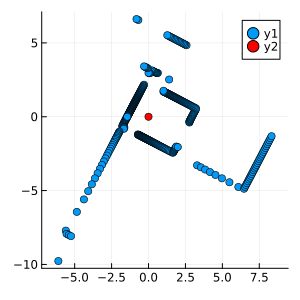

In [32]:
t = 14
x0 = _xs[t]
hd0 = _hds[t]
p0 = [x0;hd0]
z0 = _zmax*ones(length(_a))
cast_cpu!(stack(_segs), _a, p0, z0)  
x = stack(polar_inv(z0, _a));
# ------------------------
plot(size=(300,300), aspect_ratio=:equal)
scatter!(x[:,1],x[:,2])
scatter!([zeros(2)], c=:red)

In [33]:
Y = []
P = []

delta_x = 0.
delta_hd =  45/360*2π
for i=1:750
    
    x   = mvuniform(
            [x0[1] - delta_x,x0[2] - delta_x], 
            [x0[1] + delta_x,x0[2] + delta_x])
    
    hd = uniform(
            hd0 - delta_hd, 
            hd0 + delta_hd)
    
    p = [x;hd] 
    push!(P,p)
    
    z = _zmax*ones(length(_a))
    cast_cpu!(stack(_segs), _a, p, z)  
    y = stack(polar_inv(z, _a));
    
    push!(Y,y)
end
x = stack(polar_inv(z0, _a));

In [34]:
std = 0.5
L   = Dict()
ws  = [1,5,10,20]

for w in ws
    L[w] = [  ddppp_logpdf(x,y,std,w) for y in Y];
    println("w=$(w) ... done")
end

w=1 ... done
w=5 ... done
w=10 ... done
w=20 ... done


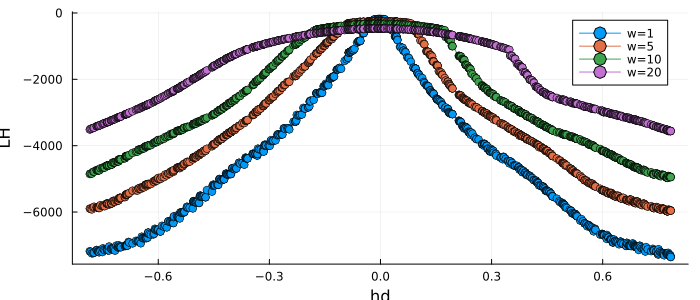

In [35]:
phd  = [p[3]-hd0 for p in P]
perm = sortperm(phd)

myplot = plot(size=(700,300), xlabel="hd", ylabel="LH")
for w in ws
    ell = L[w]
    plot!(phd[perm], ell[perm], marker=:o, label="w=$(w)")
end
myplot

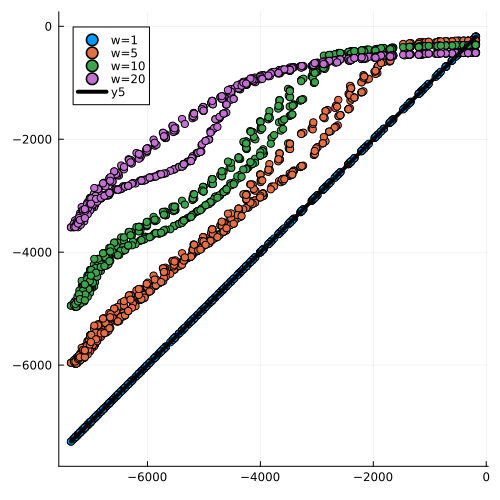

In [36]:
Lbase = L[ws[1]]

myplot = plot(size=(500,500), aspect_ratio=:equal)

for w in ws
    ell = L[w]
    scatter!(Lbase, ell, label="w=$(w)")
end
plot!([[minimum(Lbase);minimum(Lbase)],[maximum(Lbase);maximum(Lbase)]], c=:black, linewidth=4)
myplot

## Experiment - Change postion

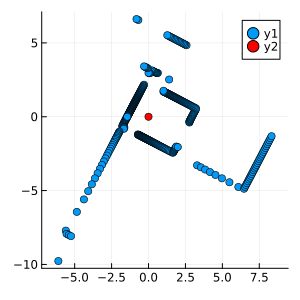

In [37]:
t = 14
x0 = _xs[t]
hd0 = _hds[t]
p0 = [x0;hd0]
z0 = _zmax*ones(length(_a))
cast_cpu!(stack(_segs), _a, p0, z0)  
x = stack(polar_inv(z0, _a));
# ------------------------
plot(size=(300,300), aspect_ratio=:equal)
scatter!(x[:,1],x[:,2])
scatter!([zeros(2)], c=:red)

In [38]:
Y = []
P = []

delta_x = 1.
delta_hd = 0.
for i=1:1_000
    
    x   = mvuniform(
            [x0[1] - delta_x,x0[2] - delta_x], 
            [x0[1] + delta_x,x0[2] + delta_x])
    
    hd = uniform(
            hd0 - delta_hd, 
            hd0 + delta_hd)
    
    p = [x;hd] 
    push!(P,p)
    
    z = _zmax*ones(length(_a))
    cast_cpu!(stack(_segs), _a, p, z)  
    y = stack(polar_inv(z, _a));
    
    push!(Y,y)
end
x = stack(polar_inv(z0, _a));

In [52]:
std = .2
L   = Dict()
ws  = [1,5,10,20]

for w in ws
    L[w] = [  ddppp_logpdf(x,y,std,w) for y in Y];
    println("w=$(w) ... done")
end

w=1 ... done
w=5 ... done
w=10 ... done
w=20 ... done


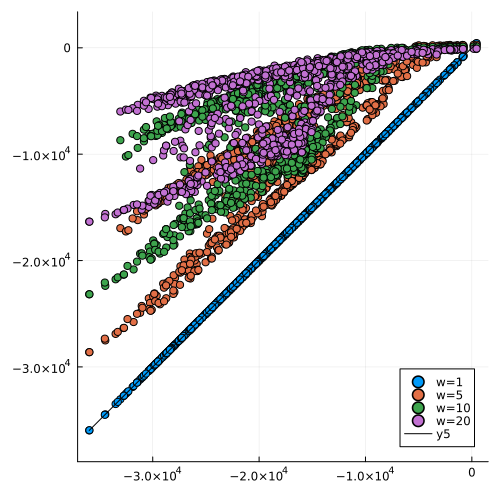

In [53]:
Lbase = L[ws[1]]

myplot = plot(size=(500,500), aspect_ratio=:equal)

for w in ws
    ell = L[w]
    scatter!(Lbase, ell, label="w=$(w)")
end
plot!([[minimum(Lbase);minimum(Lbase)],[maximum(Lbase);maximum(Lbase)]], c=:black, linewidth=1)
myplot

-35969.44059692844
443.86788694743467


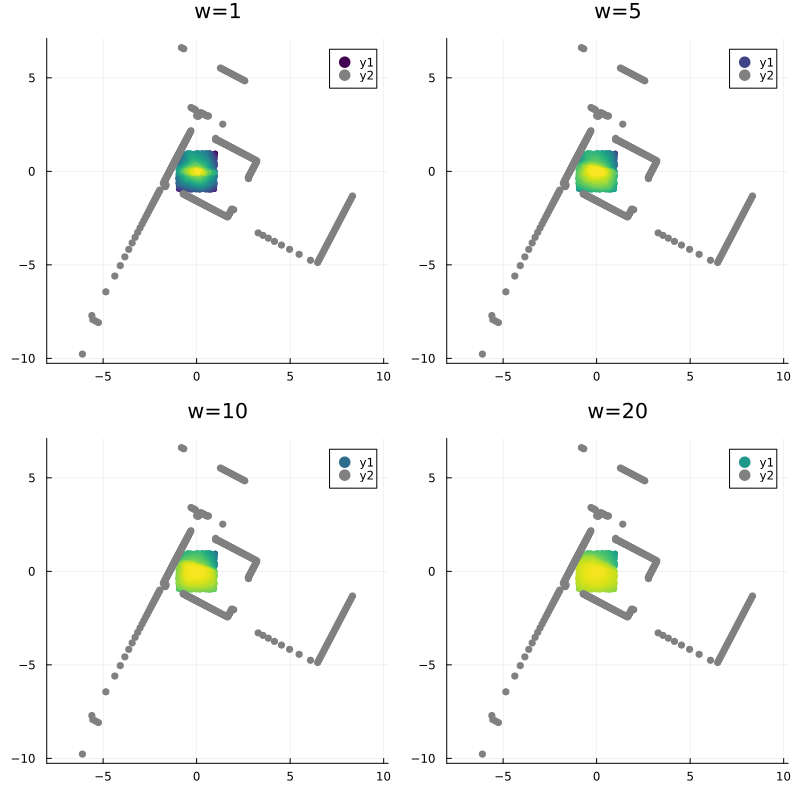

In [55]:
phd = [p[3]-hd0 for p in P]
perm = sortperm(phd)

cmin = minimum(L[ws[1]])
cmax = maximum(L[ws[1]])

println(cmin)
println(cmax)

plots = []
for w in ws
    ell = L[w]
    perm = sortperm(ell)
    # ------------------------
    myplot = plot(size=(600,600), aspect_ratio=:equal, title="w=$(w)", colorbar=nothing)
    scatter!([p[1:2]-x0 for p in P[perm]], zcolor=ell[perm], clim=(cmin, cmax), markersize=3, color=:viridis, markerstrokewidth=0)
#     scatter!([zeros(2)], c=:red)
    scatter!(x[:,1],x[:,2], c=:gray, markerstrokewidth=0)
    push!(plots, myplot)
end
plot(plots..., layout=grid(2, div(length(ws),2)) ,size=(800,800))